In [3]:
# import keras
import keras
keras.__version__

'2.8.0'

# Recursive neural networks

[...]

## Recursive layer in the Keras package


The process we implemented using the Numpy library is equivalent to a simple layer called The SimpleRNN of the Keras package:

In [4]:
from keras.layers import SimpleRNN

However, there is a small difference between these implementations: the SimpleRNN layer divides the sequences into batches (this is done by all Keras layers) — it does not process individual sequences as it did in the example implemented with The Numpy library. Therefore, this layer accepts input objects with a shape (input_value, time_steps, entry_characteristics) and not (time_steps, entry_characteristics).

The SimpleRNN layer, like all recursive layers of the Keras package, can be run in two modes: it can return full sequences of consecutive output objects for each step of time (three-dimensional tensors in shape (input_value, time_steps, entry_characteristics)) or only the last output objects of individual input sequences (two-dimensional tensors in shape (time_steps, entry_characteristics)). The selection of the operating mode is made using the return_sequences argument. Let's analyze an example where the SimpleRNN layer is applied, and the output is returned only when processing the last step of time:

In [5]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [6]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Sometimes it's a good idea to create a stack of several recursive layers. This increases the power of representation by the network. With this configuration, all intermediate layers must return the full sequence of output objects:

In [7]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # The last layer returns only the last output object.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's use such a model to solve the problem of rating movie reviews. Let's start with the pre-processing of data:

In [8]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # The number of words treated as characteristics.
maxlen = 500  # Cuts reviews after this number of words belonging to the set of max_features words most common in the set.
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'training sequences')
print(len(input_test), 'test sequences')

print('Sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('Shape of the object input_train:', input_train.shape)
print('Shape of the object input_test:', input_test.shape)


Loading data...
17473536/17464789 [==============================] - 0s 0us/step
25000 training sequences
25000 test sequences
Sequences (samples x time)
Shape of the object input_train: (25000, 500)
Shape of the object input_test: (25000, 500)


Let's train a simple recursive network using the Embedding layer and the SimpleRNN layer.

In [9]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 29s 173ms/step - loss: 0.6280 - acc: 0.6360 - val_loss: 0.8453 - val_acc: 0.5480
Epoch 2/10
157/157 [==============================] - 27s 171ms/step - loss: 0.3997 - acc: 0.8299 - val_loss: 0.6027 - val_acc: 0.7452
Epoch 3/10
157/157 [==============================] - 28s 178ms/step - loss: 0.3043 - acc: 0.8759 - val_loss: 0.3943 - val_acc: 0.8206
Epoch 4/10
157/157 [==============================] - 27s 171ms/step - loss: 0.2380 - acc: 0.9072 - val_loss: 0.3743 - val_acc: 0.8548
Epoch 5/10
157/157 [==============================] - 27s 171ms/step - loss: 0.1896 - acc: 0.9298 - val_loss: 0.4064 - val_acc: 0.8414
Epoch 6/10
157/157 [==============================] - 27s 171ms/step - loss: 0.1501 - acc: 0.9455 - val_loss: 0.4117 - val_acc: 0.8312
Epoch 7/10
157/157 [==============================] - 27s 172ms/step - loss: 0.1010 - acc: 0.9646 - val_loss: 0.6012 - val_acc: 0.7618
Epoch 8/10
157/157 [==============================] - 2

Now we can view the accuracy graphs and losses in the training and validation processes:

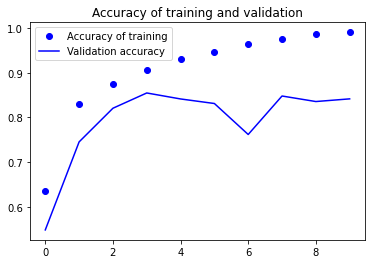

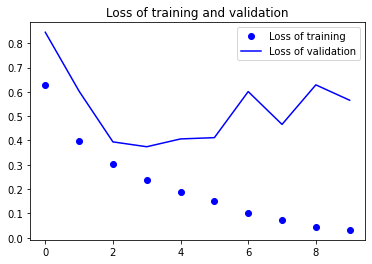

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Accuracy of training')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy of training and validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()

[...]

## Example of a LSTM layer implemented in Keras

It's time to look at a practical example of how to use the LSTM layer. We will configure the model in which such a layer will be located and train it on the IMDB dataset. It resembles the previously presented model with the SimpleRNN layer. We will specify only the number of dimensions of the LSTM output object. The remaining arguments of this layer (there are many) will be left with the default values. The default settings of the Keras package are well thought out and usually "just work" without having to spend a lot of time manually tuning the parameters.

In [11]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 59s 360ms/step - loss: 0.5520 - acc: 0.7495 - val_loss: 0.3813 - val_acc: 0.8474
Epoch 2/10
157/157 [==============================] - 56s 358ms/step - loss: 0.3290 - acc: 0.8674 - val_loss: 0.2934 - val_acc: 0.8798
Epoch 3/10
157/157 [==============================] - 57s 362ms/step - loss: 0.2495 - acc: 0.9054 - val_loss: 0.2821 - val_acc: 0.8790
Epoch 4/10
157/157 [==============================] - 57s 365ms/step - loss: 0.2085 - acc: 0.9236 - val_loss: 0.2962 - val_acc: 0.8910
Epoch 5/10
157/157 [==============================] - 57s 363ms/step - loss: 0.1810 - acc: 0.9347 - val_loss: 0.3335 - val_acc: 0.8516
Epoch 6/10
157/157 [==============================] - 57s 363ms/step - loss: 0.1651 - acc: 0.9433 - val_loss: 0.2883 - val_acc: 0.8872
Epoch 7/10
157/157 [==============================] - 56s 359ms/step - loss: 0.1453 - acc: 0.9486 - val_loss: 0.3203 - val_acc: 0.8644
Epoch 8/10
157/157 [==============================] - 5

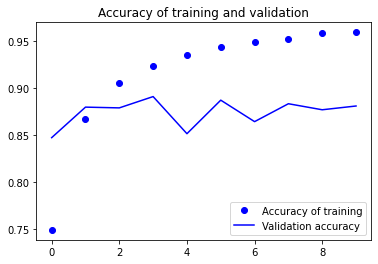

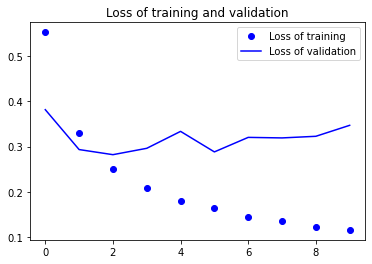

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Accuracy of training')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Accuracy of training and validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Loss of training')
plt.plot(epochs, val_loss, 'b', label='Loss of validation')
plt.title('Loss of training and validation')
plt.legend()

plt.show()